# CAVI vs CAVI-EB vs SVI vs SVI-EB pCMF

In [1]:
from pCMF.misc import utils
from pCMF.models.pcmf import cavi, svi

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from scipy.stats import gamma

import operator
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Experiment parameters
N = 1000 # number of observations
P = 20 # observation space dimensionality
K = 10 # latent space dimensionality
C = 2 # number of clusters

# Generate data set
z_p = 0.5
eps = 5.
Y, D, X, R, V, U, clusters = utils.generate_data(N, P, K, C=C, zero_prob=z_p,
                                                 eps=eps, return_all=True)

Y_train, Y_test, U_train, U_test, c_train, c_test = train_test_split(Y, U.T, clusters, test_size=0.2, random_state=42)

In [3]:
T = 60.
S = 1.

In [4]:
# Run PCA
pca_U = PCA(n_components=K).fit_transform(np.log(Y_train + 1.))
pca_tsne = TSNE(n_components=2).fit_transform(pca_U)

In [5]:
# Run CAVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
print('PCMF:')
infpcmf = cavi.CoordinateAscentVI(Y_train, alpha, beta, pi_D)
pcmf_ll = infpcmf.run_cavi(n_iterations=4000, empirical_bayes=False, return_ll=True, sampling_rate=S, max_time=T)
pcmf_U = infpcmf.a[0] / infpcmf.a[1] # VI estimate is the mean of the variational approximation
pcmf_V = infpcmf.b[0] / infpcmf.b[1]
pcmf_tsne = TSNE(n_components=2).fit_transform(pcmf_U)

PCMF:
Iteration 47/4000. Log-likelihood: 21.247. Elapsed: 60 seconds


In [6]:
# Run CAVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
print('PCMF:')
infpcmfeb = cavi.CoordinateAscentVI(Y_train, alpha, beta, pi_D)
pcmfeb_ll = infpcmfeb.run_cavi(n_iterations=4000, empirical_bayes=True, return_ll=True, sampling_rate=S, max_time=T)
pcmfeb_U = infpcmfeb.a[0] / infpcmfeb.a[1] # VI estimate is the mean of the variational approximation
pcmfeb_V = infpcmfeb.b[0] / infpcmfeb.b[1]
pcmfeb_tsne = TSNE(n_components=2).fit_transform(pcmfeb_U)

PCMF:
Iteration 34/4000. Log-likelihood: 21.454. Elapsed: 61 seconds


In [7]:
# for _ in range(100):
#     pcmf_ll = inf.run_cavi(n_iterations=1, empirical_bayes=False, return_ll=True, sampling_rate=S, max_time=T)
#     pcmf_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation
#     pcmf_pca = PCA(n_components=2).fit_transform(pcmf_U)
#     for c in range(C):
#         plt.scatter(pcmf_pca[c_train==c, 0], pcmf_pca[c_train==c, 1], s=30, alpha=0.7)
#     plt.show()

In [8]:
# Run SVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
print('Stochastic PCMF:')
infpcmfsvi = svi.StochasticVI(Y_train, alpha, beta, pi_D)
pcmfsvi_ll = infpcmfsvi.run_svi(n_iterations=4000, minibatch_size=100, empirical_bayes=False, return_ll=True, sampling_rate=S, max_time=T)
pcmfsvi_U = infpcmfsvi.a[0] / infpcmfsvi.a[1] # VI estimate is the mean of the variational approximation
pcmfsvi_V = infpcmfsvi.b[0] / infpcmfsvi.b[1]
pcmfsvi_tsne = TSNE(n_components=2).fit_transform(pcmfsvi_U)

Stochastic PCMF:
Iteration 232/4000. Log-likelihood: 23.185. Elapsed: 60 seconds


In [9]:
# Run SVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
print('Stochastic PCMF:')
infpcmfsvieb = svi.StochasticVI(Y_train, alpha, beta, pi_D)
pcmfsvieb_ll = infpcmfsvieb.run_svi(n_iterations=4000, minibatch_size=100, empirical_bayes=True, return_ll=True, sampling_rate=S, max_time=T)
pcmfsvieb_U = infpcmfsvieb.a[0] / infpcmfsvieb.a[1] # VI estimate is the mean of the variational approximation
pcmfsvieb_V = infpcmfsvieb.b[0] / infpcmfsvieb.b[1]
pcmfsvieb_tsne = TSNE(n_components=2).fit_transform(pcmfsvieb_U)

Stochastic PCMF:
Iteration 240/4000. Log-likelihood: 22.457. Elapsed: 60 seconds


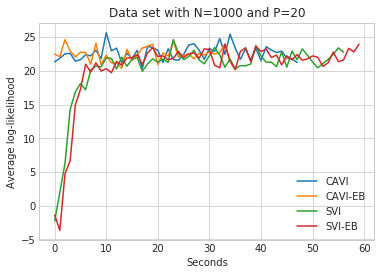

In [10]:
plt.plot(pcmf_ll[1], label='CAVI')
plt.plot(pcmfeb_ll[1], label='CAVI-EB')
plt.plot(pcmfsvi_ll[1], label='SVI')
plt.plot(pcmfsvieb_ll[1], label='SVI-EB')
plt.ylabel('Average log-likelihood')
plt.xlabel('Seconds')
plt.title('Data set with N={} and P={}'.format(N, P))
plt.legend()
plt.show()

In [11]:
pcmf_dll = utils.log_likelihood(Y_train, pcmf_U, pcmf_V, infpcmf.p)
pcmfeb_dll = utils.log_likelihood(Y_train, pcmfeb_U, pcmfeb_V, infpcmfeb.p)
pcmfsvi_dll = utils.log_likelihood(Y_train, pcmfsvi_U, pcmfsvi_V, infpcmfsvi.p)
pcmfsvieb_dll = utils.log_likelihood(Y_train, pcmfsvieb_U, pcmfsvieb_V, infpcmfsvieb.p)

scores = {'SVI': pcmfsvi_dll, 'CAVI-EB': pcmfeb_dll, 'SVI-EB': pcmfsvieb_dll, 'CAVI': pcmf_dll}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Full data log-likelihood:')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

Full data log-likelihood:
- CAVI: 22.5
- CAVI-EB: 22.4
- SVI-EB: 22.2
- SVI: 22.1


In [12]:
pcmf_holl = infpcmf.predictive_ll(Y_test)
pcmfeb_holl = infpcmfeb.predictive_ll(Y_test)
pcmfsvi_holl = infpcmfsvi.predictive_ll(Y_test)
pcmfsvieb_holl = infpcmfsvieb.predictive_ll(Y_test)

scores = {'SVI': pcmfsvi_holl, 'CAVI-EB': pcmfeb_holl, 'SVI-EB': pcmfsvieb_holl, 'CAVI': pcmf_holl}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Held-out log-likelihood:')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

Held-out log-likelihood:
- CAVI: 23.0
- CAVI-EB: 22.8
- SVI-EB: 22.6
- SVI: 22.6


In [13]:
true_silh = silhouette_score(U_train, c_train)
pcmf_silh = silhouette_score(pcmf_U, c_train)
pcmfeb_silh = silhouette_score(pcmfeb_U, c_train)
pcmfsvi_silh = silhouette_score(pcmfsvi_U, c_train)
pcmfsvieb_silh = silhouette_score(pcmfsvieb_U, c_train)
pca_silh = silhouette_score(pca_U, c_train)

scores = {'SVI': pcmfsvi_silh, 'CAVI-EB': pcmfeb_silh, 'SVI-EB': pcmfsvieb_silh, 'CAVI': pcmf_silh, 'PCA': pca_silh}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Silhouette scores (higher is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))
    
print('\nSilhouette of true U:')
print('%0.3f' % true_silh)

Silhouette scores (higher is better):
- CAVI-EB: 0.206
- CAVI: 0.167
- SVI: 0.0814
- SVI-EB: 0.0583
- PCA: -6.11e-05

Silhouette of true U:
0.555


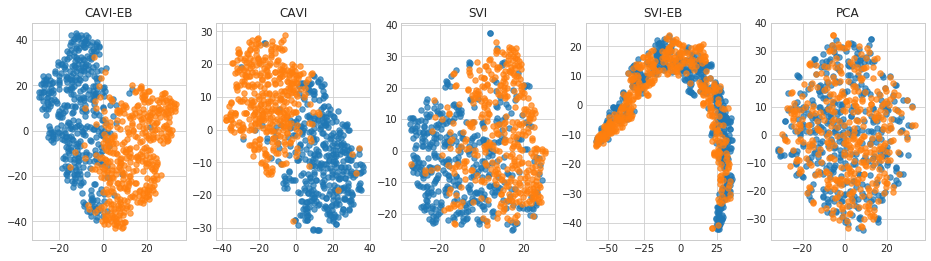

In [14]:
# Plot in decreasing silhouette order
U_list = [pcmf_tsne, pcmfeb_tsne, pcmfsvi_tsne, pcmfsvieb_tsne, pca_tsne]
title_list = ['CAVI', 'CAVI-EB', 'SVI', 'SVI-EB', 'PCA']

assert len(U_list) == len(title_list)

n_results = len(U_list)

fig = plt.figure(figsize=(16, 4))

s = 30
alpha = 0.7
labels=None
for i in range(len(U_list)):
    ax = plt.subplot(1, n_results, i+1)
    handlers = []
    for c in range(C):
        h = ax.scatter(U_list[title_list.index(sorted_scores[i][0])][c_train==c, 0], U_list[title_list.index(sorted_scores[i][0])][c_train==c, 1], s=s, alpha=alpha)
        handlers.append(h)
    if labels is not None:
        ax.legend(handlers, labels, scatterpoints=1)
    plt.title(sorted_scores[i][0])
plt.show()